In [10]:
import numpy as np
import scipy.stats as stats
from scipy.signal import find_peaks
import pandas as pd 
import matplotlib.pyplot as plt      
import torch

# Necessary functions to preprocess the data, get the features and plot them


In [114]:
# initial dataframe
def pre_process(data_path,timestamps=None):
    data=pd.read_excel(data_path)
    # print("The RAW DATA info is:")
    # data.info()

    #preprocessing to get it in my order
    df=data.copy() #copying it so original data is not affected
    df=df.dropna()
    df=df.drop(["Time - Voltage","Time - Resistance","Time - Force"],axis=1)
    df=df.rename({
        "Time - Current":"Time",
        "Current (kA) - Current":"Current (kA)",
        "Voltage (V) - Voltage":"Voltage (V)",
        "Resistance (Ohm) - Resistance":"Resistance (Ohm)",
        "Force (kg) - Force":"Force (kgf)"
    },axis=1)

    if timestamps:
        dfs=df.loc[timestamps]
        return dfs
    else:
        return df
    # print("\n the formatted data info is: ")
    # df.info()

In [118]:

def get_features(sensor,timestamps=None):
    feature_list={'mean':[],
                'median':[],
                'mode':[],
                'std':[],
                'max':[],
                "min":[],
                "skew":[],
                "kurt":[],
                "q_25":[],
                "q_50":[],
                "q_75":[],
                "cov":[],
                "peaks":[]
                }
    for i in range(1,69,1):
        data_path=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{i}.xlsx"
        df=pre_process(data_path,timestamps=timestamps)
        signal=np.array(df[sensor])
        signal_norm=(signal-np.mean(signal))/np.std(signal)

        feature_list["mean"].append(np.round(np.mean(signal),4))
        feature_list['median'].append(np.round(np.median(signal),4))
        feature_list['mode'].append(np.round(stats.mode(signal, keepdims=True)[0][0],4))
        feature_list['std'].append(np.round(np.std(signal),4))
        feature_list['max'].append(np.round(np.max(signal),4))
        feature_list['min'].append(np.round(np.min(signal),4))
        feature_list['skew'].append(np.round(stats.skew(signal),4))
        feature_list['kurt'].append(np.round(stats.kurtosis(signal),4))
        feature_list['q_25'].append(np.round(np.percentile(signal, [25]),4))
        feature_list['q_50'].append(np.round(np.percentile(signal, [50]),4))
        feature_list['q_75'].append(np.round(np.percentile(signal, [75]),4))
        feature_list['cov'].append(np.round(np.std(signal) / np.mean(signal),4))
        peaks, _ = find_peaks(signal)
        feature_list['peaks'].append(len(peaks))

    return feature_list


In [119]:
def plot_features(dataframe,sensor):
    n_features=len(dataframe.columns)
    n_cols=3
    n_rows=-(-n_features//n_cols)

    fig, axes= plt.subplots(n_rows,n_cols, figsize=(15,4*n_rows))
    axes=axes.flatten()
    plt.suptitle(f"Extracted features of {sensor}",fontsize=16)

    for i, feature in enumerate(dataframe.columns):
        axes[i].plot(dataframe.index,dataframe[feature])
        axes[i].set_title(feature)
        axes[i].set_xlabel("Spot No.")
        axes[i].set_ylabel(feature)

    for j in range(i+1,len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Here we can call for features instance and next plot them


In [ ]:
# extracting all the statistical features for each sensor
feature_list_Resistance=get_features(sensor="Resistance (Ohm)")
feature_list_Force=get_features(sensor="Force (kgf)")
feature_list_Current=get_features(sensor="Current (kA)")

# creating respective dataframes

df_Resistance=pd.DataFrame(feature_list_Resistance,columns=feature_list_Resistance.keys())
df_Resistance.index = range(1, len(df_Resistance) + 1)

df_Current=pd.DataFrame(feature_list_Current,columns=feature_list_Current.keys())
df_Current.index = range(1, len(df_Current) + 1)

df_Force=pd.DataFrame(feature_list_Force,columns=feature_list_Force.keys())
df_Force.index = range(1, len(df_Force) + 1)




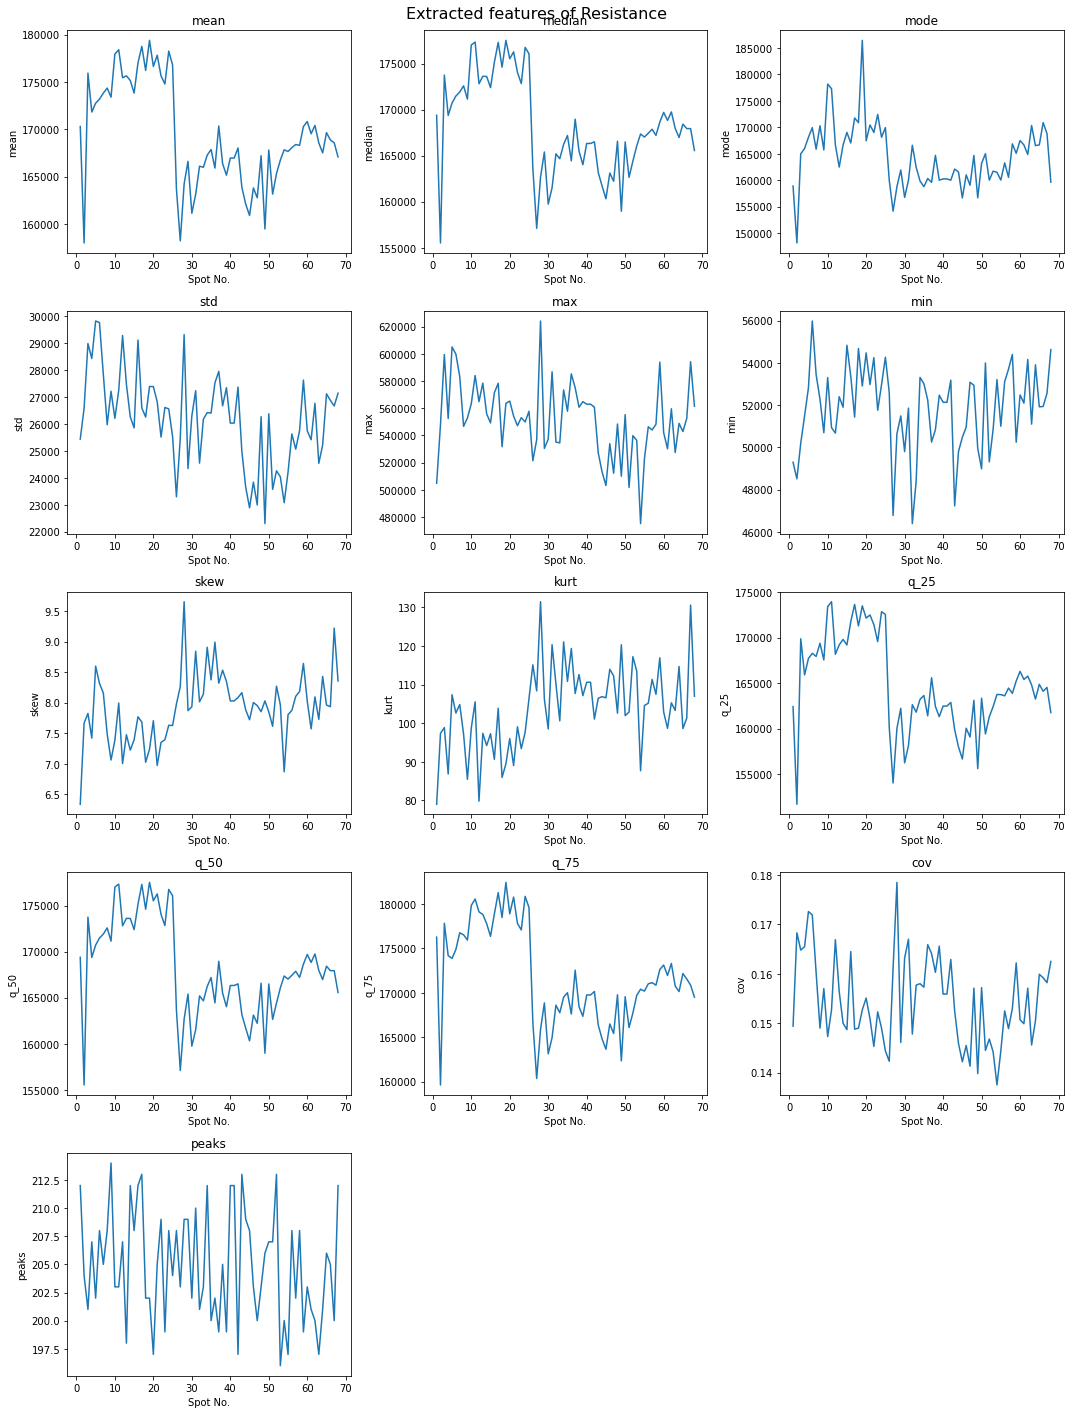

In [113]:
# plotting extracted features for each sensor
plot_features(dataframe=df_Resistance,sensor="Resistance")

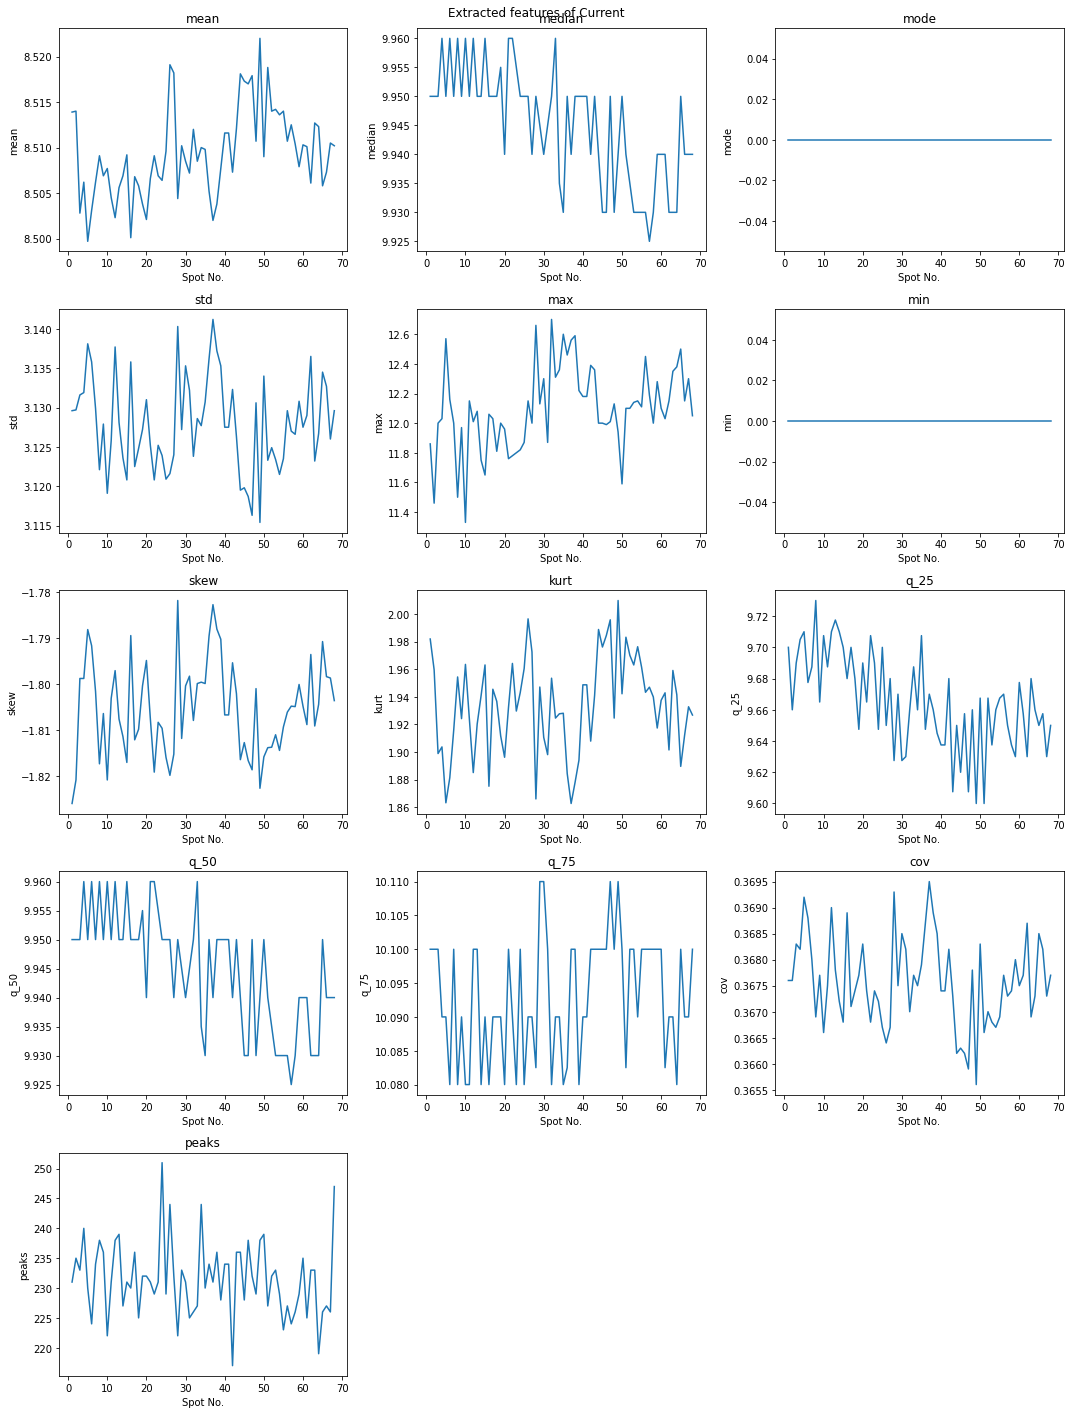

In [93]:
plot_features(dataframe=df_Current,sensor="Current")

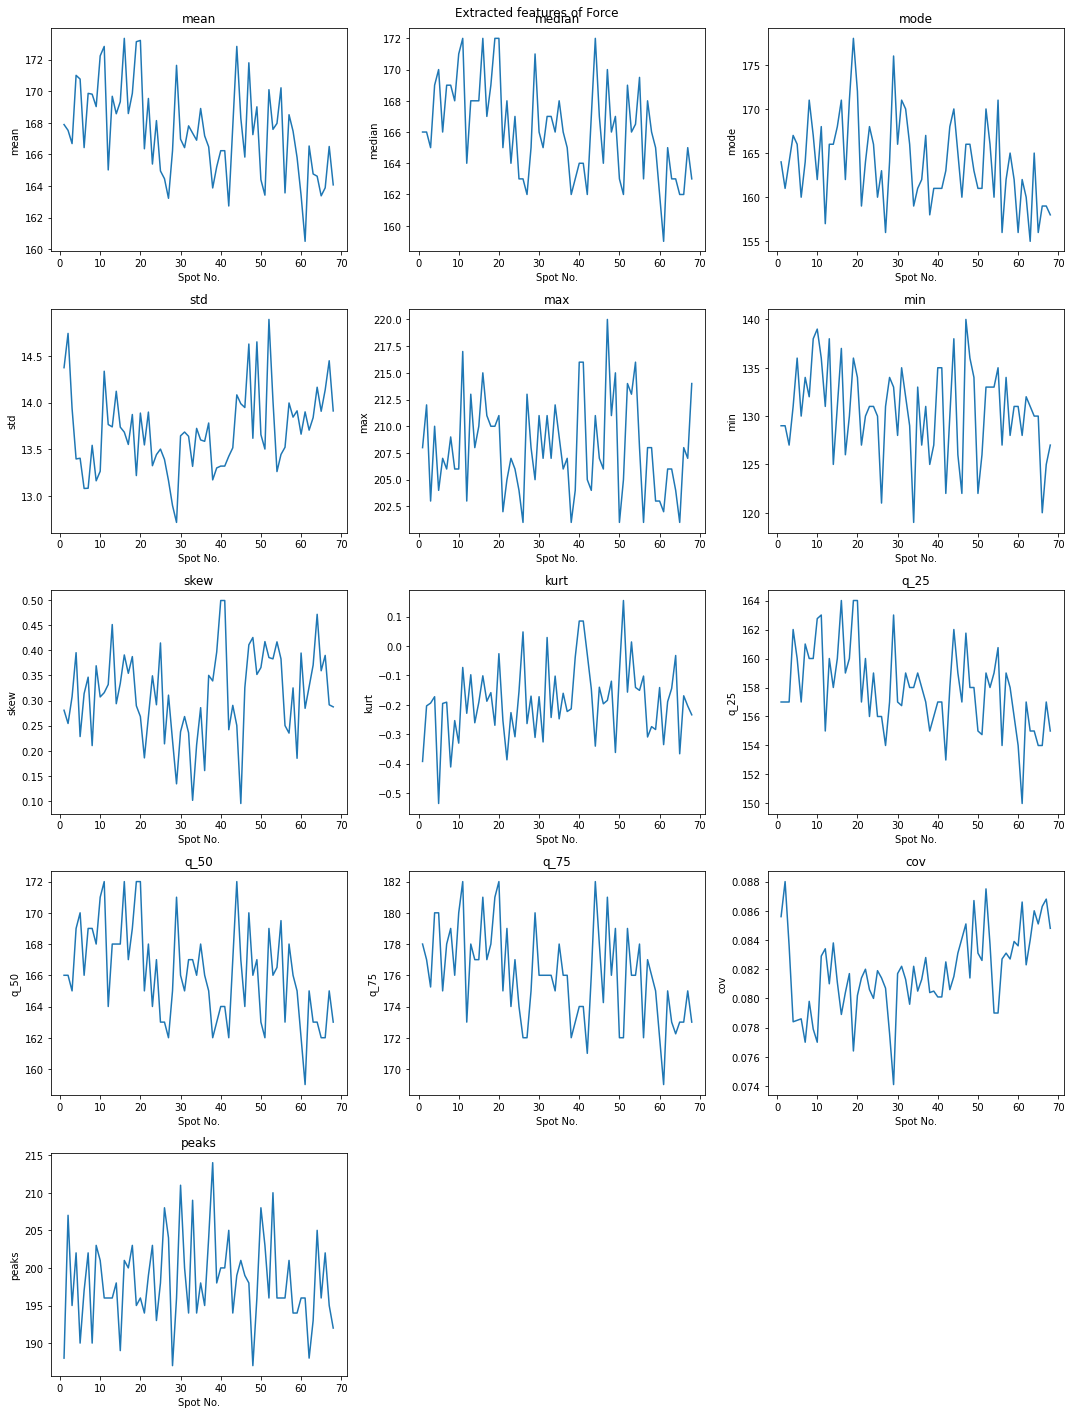

In [94]:
plot_features(dataframe=df_Force,sensor='Force')

# Space for rough


In [120]:
data_path=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{1}.xlsx"
data=pd.read_excel(data_path)
# print("The RAW DATA info is:")
# data.info()

#preprocessing to get it in my order
df=data.copy() #copying it so original data is not affected
df=df.dropna()
df=df.drop(["Time - Voltage","Time - Resistance","Time - Force"],axis=1)
df=df.rename({
    "Time - Current":"Time",
    "Current (kA) - Current":"Current (kA)",
    "Voltage (V) - Voltage":"Voltage (V)",
    "Resistance (Ohm) - Resistance":"Resistance (Ohm)",
    "Force (kg) - Force":"Force (kgf)"
},axis=1)

In [121]:
timestamps=np.arange(110,747,1)

In [123]:
# df.loc[timestamps]

In [ ]:
import torch